In [2]:
#Import nessesary libraries

import pandas as pd
import sqlite3
from urllib.request import urlopen
from bs4 import BeautifulSoup
from datetime import datetime
import numpy as np
from itertools import permutations
from collections import OrderedDict
from datetime import timedelta

# pip install geopy #This is used to calculate distance based on lat and long... no need to reinvent the wheel...

from geopy.distance import great_circle

import matplotlib.pyplot as plt
%matplotlib inline



In [34]:
#Read in top airport data from supplied files
path = 'hw_5_data/'
#db_name = 'airports2.db'
db_name = 'airport_db'
top_airpots = pd.read_csv(path+'top_airports.csv' )
airport_info = pd.read_csv(path+'ICAO_airports.csv' )



In [3]:

airport_info['ICAO'] = airport_info['ident']
combined_info = top_airpots.merge(airport_info, on='ICAO')




$\textbf{Make SQL tables}$

In [35]:
connection = sqlite3.connect(path+db_name)
cursor = connection.cursor()

#Create a table for the airport info and a table for the corresponding weather
sql_info_cmd = """CREATE TABLE info (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    ICAO TEXT,
    name TEXT,
    city TEXT,
    latitude_deg FLOAT,
    longitude_deg FLOAT,
    elevation FLOAT,
    enplanements INT)"""


sql_weather_cmd = """CREATE TABLE weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    ICAO TEXT,
    date DATE,
    temp_high FLOAT,
    temp_ave FLOAT,
    temp_low FLOAT,
    humidity_ave FLOAT,
    precipitation FLOAT)"""

cursor.execute(sql_info_cmd)
cursor.execute(sql_weather_cmd)
connection.commit()

$\textbf{Scrape data from weather underground}$

In [54]:
# Helper functions to format dates and get date range to request data


def inc_by_year(date):
    '''
    Helper function to incriment a given date by one year,
    expects to be in format %Y/%m/%d
    '''
    date_temp = date.split('/')
    year_inc = str(int(date_temp[0])+1)
    new_date = '{}/{}/{}'.format(year_inc, date_temp[1], date_temp[2])
    return new_date

def inc_by_day(date):
    '''
    Helper function to incriment a given date by one day,
    expects to be in format %Y/%m/%d
    '''
    date_temp = date.split('/')
    day_inc = str(int(date_temp[2])+1)
    new_date = '{}/{}/{}'.format(date_temp[0], date_temp[1], day_inc)
    return new_date


def get_date_range_to_query(date_start,date_end):
    '''
    Weatherunderground historical data only returns a years worth of data at a time,
    this function takes the users defined date range, and returns a list of start and end dates divided
    into year long chunks. 
    '''
    if date_end == 'today':
        today = datetime.now()
        date_end = '{}/{}/{}'.format(today.year, today.month, today.day)
    
    date_range = list()
    dates_temp_list = list()
    
    dates_temp_list.append(date_start)
    
    date_delta = (datetime.strptime(date_end, '%Y/%m/%d') - datetime.strptime(date_start, '%Y/%m/%d'))
    date_delta_years = int(date_delta.total_seconds()/(60*60*24*365.2425))
    
    for iyear in range(date_delta_years):
        temp_date = inc_by_year(dates_temp_list[iyear])
        dates_temp_list.append(temp_date)
        
    lgc_first_interation = True    
    
    for idate in range(len(dates_temp_list)):
        if lgc_first_interation:
            try:
                date_range.append([dates_temp_list[idate],dates_temp_list[idate+1]])
            except:
                date_range.append([dates_temp_list[idate],date_end])           
        else:
            try:
                date_range.append([inc_by_day(dates_temp_list[idate]),dates_temp_list[idate+1]])
            except:
                date_range.append([dates_temp_list[idate],date_end])
        lgc_first_interation = False  
    
    return date_range


get_date_range_to_query(date_start,date_end='today')
    
    
    

[['2013/2/11', '2014/2/11'],
 ['2014/2/12', '2015/2/11'],
 ['2015/2/12', '2016/2/11'],
 ['2016/2/12', '2017/2/11'],
 ['2017/2/12', '2018/2/11'],
 ['2018/2/11', '2018/3/11']]

In [4]:
def get_data_from_db(db_name, path, sql_cmd):
        connection = sqlite3.connect(path+db_name)
        cursor = connection.cursor()
        connection.row_factory = lambda cursor, row: row[0]
        c = connection.cursor()
        data = c.execute(sql_cmd).fetchall()
        connection.close()
        return data
    

In [18]:


#Create dictionary to hold all the correlation data
airport_pairs_dict = {}
column_names = ['Airport_pairs','highT_1','highT_3','highT_7',\
                'precip_1','precip_3','precip_7','dist','long_delta' ]
for key in column_names: 
    airport_pairs_dict[key] = list()
    
    

###Get airport codes from database
sql_cmd = "SELECT ICAO FROM airport_info"
airport_code = get_data_from_db(db_name,path, sql_cmd)

indx = 0

##### temporary code to eliminate bad files in database ###
bad_airport = np.array(['KIAH','KLGA','KMSY','KIND'])
airport_code = np.asarray(airport_code)
cuts = np.ones(shape=airport_code.shape, dtype=bool)
bad_indx = np.where(airport_code == 'KIAH')#np.array([word for word in bad_airport]))
cuts[bad_indx] = 0
bad_indx = np.where(airport_code == 'KLGA')#[word for word in bad_airport])
cuts[bad_indx] = 0
bad_indx = np.where(airport_code == 'KMSY')#[word for word in bad_airport])
cuts[bad_indx] = 0
bad_indx = np.where(airport_code == 'KIND')#[word for word in bad_airport])
cuts[bad_indx] = 0


### calculate the correlations for all permutations of airports
for combo in permutations(airport_code[cuts],2):
    
    indx += 1
    
    sql_cmd_highT_1 = "SELECT high_temp FROM airport_weather where ICAO = " + '"' + str(combo[0] + '"')
    sql_cmd_highT_2 = "SELECT high_temp FROM airport_weather where ICAO = " + '"' + str(combo[1] + '"')
    
    sql_cmd_precip_1 = "SELECT precipitation FROM airport_weather where ICAO = " + '"' + str(combo[0] + '"')
    sql_cmd_precip_2 = "SELECT precipitation FROM airport_weather where ICAO = " + '"' + str(combo[1] + '"')
    
    sql_cmd_lat_1 = "SELECT latitude_deg FROM airport_info where ICAO = " + '"' + str(combo[0] + '"')
    sql_cmd_lat_2 = "SELECT latitude_deg FROM airport_info where ICAO = " + '"' + str(combo[1] + '"')
    
    sql_cmd_long_1 = "SELECT longitude_deg FROM airport_info where ICAO = " + '"' + str(combo[0] + '"')
    sql_cmd_long_2 = "SELECT longitude_deg FROM airport_info where ICAO = " + '"' + str(combo[1] + '"')
    

    high_temp_1 = get_data_from_db(db_name,path,sql_cmd_highT_1)
    high_temp_2 = get_data_from_db(db_name,path,sql_cmd_highT_2)
    
    precip_1 = get_data_from_db(db_name,path,sql_cmd_precip_1)
    precip_2 = get_data_from_db(db_name,path,sql_cmd_precip_2)
    
    lat_1 = get_data_from_db(db_name,path,sql_cmd_lat_1)[0]
    lat_2 = get_data_from_db(db_name,path,sql_cmd_lat_2)[0]
    
    long_1 = get_data_from_db(db_name,path,sql_cmd_long_1)[0]
    long_2 = get_data_from_db(db_name,path,sql_cmd_long_2)[0]
    
    
    one_highT_coeff   = np.corrcoef(high_temp_1[:-1],high_temp_2[1:])[0,1]
    three_highT_coeff = np.corrcoef(high_temp_1[:-3],high_temp_2[3:])[0,1]
    seven_highT_coeff = np.corrcoef(high_temp_1[:-7],high_temp_2[7:])[0,1]
    
    one_precip_coeff   = np.corrcoef(precip_1[:-1],precip_2[1:])[0,1]
    three_precip_coeff = np.corrcoef(precip_1[:-3],precip_2[3:])[0,1]
    seven_precip_coeff = np.corrcoef(precip_1[:-7],precip_2[7:])[0,1]
    
    long_delta = long_2-long_1
    
    distance = great_circle((lat_1,long_1),(lat_2,long_2)).miles
    

    airport_pairs_dict['Airport_pairs'].append(combo)
    airport_pairs_dict['highT_1'].append(one_highT_coeff)
    airport_pairs_dict['highT_3'].append(three_highT_coeff)
    airport_pairs_dict['highT_7'].append(seven_highT_coeff)
    airport_pairs_dict['precip_1'].append(one_precip_coeff)
    airport_pairs_dict['precip_3'].append(three_precip_coeff)
    airport_pairs_dict['precip_7'].append(seven_precip_coeff)
    airport_pairs_dict['dist'].append(distance)
    airport_pairs_dict['long_delta'].append(long_delta)
    
    
pairs_df = pd.DataFrame.from_dict(airport_pairs_dict).set_index('Airport_pairs') 

    
    

    
    

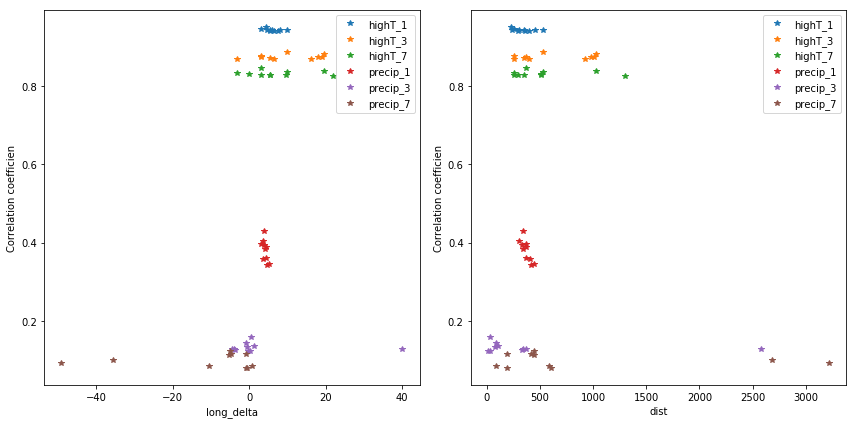

In [19]:
def plot_results(df):
    x_val = ['long_delta','dist']
    y_val = ['highT_1','highT_3','highT_7','precip_1','precip_3','precip_7']
    
    fig, ax = plt.subplots(1, len(x_val), figsize = (12, 3 * len(x_val)))
    
    for ii in range(len(x_val)):
        for jj in range(len(y_val)):
            
            ax[ii].set_xlabel(x_val[ii])
            ax[ii].set_ylabel('Correlation coefficien')
            
            df_sort = df.sort_values(by = y_val[jj], ascending=False)[:10]
            
            ax[ii].plot(df_sort[x_val[ii]], df_sort[y_val[jj]], '*', label = y_val[jj])
            ax[ii].legend(loc = 'best')
            
    plt.tight_layout()
    
    
    
    
    
    
    
    
    
    
plot_results(pairs_df)


In [33]:

#the location and 
data_needed = OrderedDict({'day_of_month': 0, 'temp_high': 1, 'temp_ave': 2, 'temp_low': 3,
                                    'humidity_ave': 8, 'precipitation': 19})
data_needed

OrderedDict([('day_of_month', 0),
             ('temp_high', 1),
             ('temp_ave', 2),
             ('temp_low', 3),
             ('humidity_ave', 8),
             ('precipitation', 19)])